In [1]:
from sentinelhub import SHConfig

config = SHConfig()
config.sh_client_id = 'sh-fe080851-d462-4304-9f4d-1b7fd7c7dc95'
config.sh_client_secret = 'XBnxUPfjs1duw9wmexDpoVmhTbY6piHw'
config.sh_base_url = 'https://sh.dataspace.copernicus.eu'
config.sh_token_url = 'https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token'

In [2]:
import datetime
import os

import matplotlib.pyplot as plt
import numpy as np

from sentinelhub import (
    CRS,
    BBox,
    DataCollection,
    DownloadRequest,
    MimeType,
    MosaickingOrder,
    SentinelHubDownloadClient,
    SentinelHubRequest,
    bbox_to_dimensions,
)

# The following is not a package. It is a file utils.py which should be in the same folder as this notebook.
from utils import plot_image

In [3]:
hyd_coords_wgs84 = (78.175278, 17.192619, 78.715668, 17.643368)
resolution = 60
hyd_bbox = BBox(bbox=hyd_coords_wgs84, crs=CRS.WGS84)
hyd_size = bbox_to_dimensions(hyd_bbox, resolution=resolution)

print(f"Image shape at {resolution} m resolution: {hyd_size} pixels")

Image shape at 60 m resolution: (968, 819) pixels


In [4]:
evalscript = """
//VERSION=3
function setup() {
  return {
    input: ["NO2", "dataMask"],
    output: { bands: 4 },
  }
}

const minVal = 0.0
const maxVal = 0.0001
const diff = maxVal - minVal

const rainbowColors = [
  [minVal, [0, 0, 0.5]],
  [minVal + 0.125 * diff, [0, 0, 1]],
  [minVal + 0.375 * diff, [0, 1, 1]],
  [minVal + 0.625 * diff, [1, 1, 0]],
  [minVal + 0.875 * diff, [1, 0, 0]],
  [maxVal, [0.5, 0, 0]],
]

const viz = new ColorRampVisualizer(rainbowColors)

function evaluatePixel(sample) {
  var rgba = viz.process(sample.NO2)
  rgba.push(sample.dataMask)
  return rgba
}
"""

In [5]:
evalscript = """
    //VERSION=3

    function setup() {
        return {
            input: [{
                bands: ["B02", "B03", "B04"]
            }],
            output: {
                bands: 3
            }
        };
    }

    function evaluatePixel(sample) {
        return [sample.B04, sample.B03, sample.B02];
    }
"""



request_true_color = SentinelHubRequest(
    evalscript=evalscript,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A.define_from(
                "s2l2a", service_url=config.sh_base_url
            ),
            time_interval=("2020-07-12", "2020-07-13"),
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
    bbox=hyd_bbox,
    size=hyd_size,
    config=config,
)

In [6]:
image = request_true_color.get_data()[0]

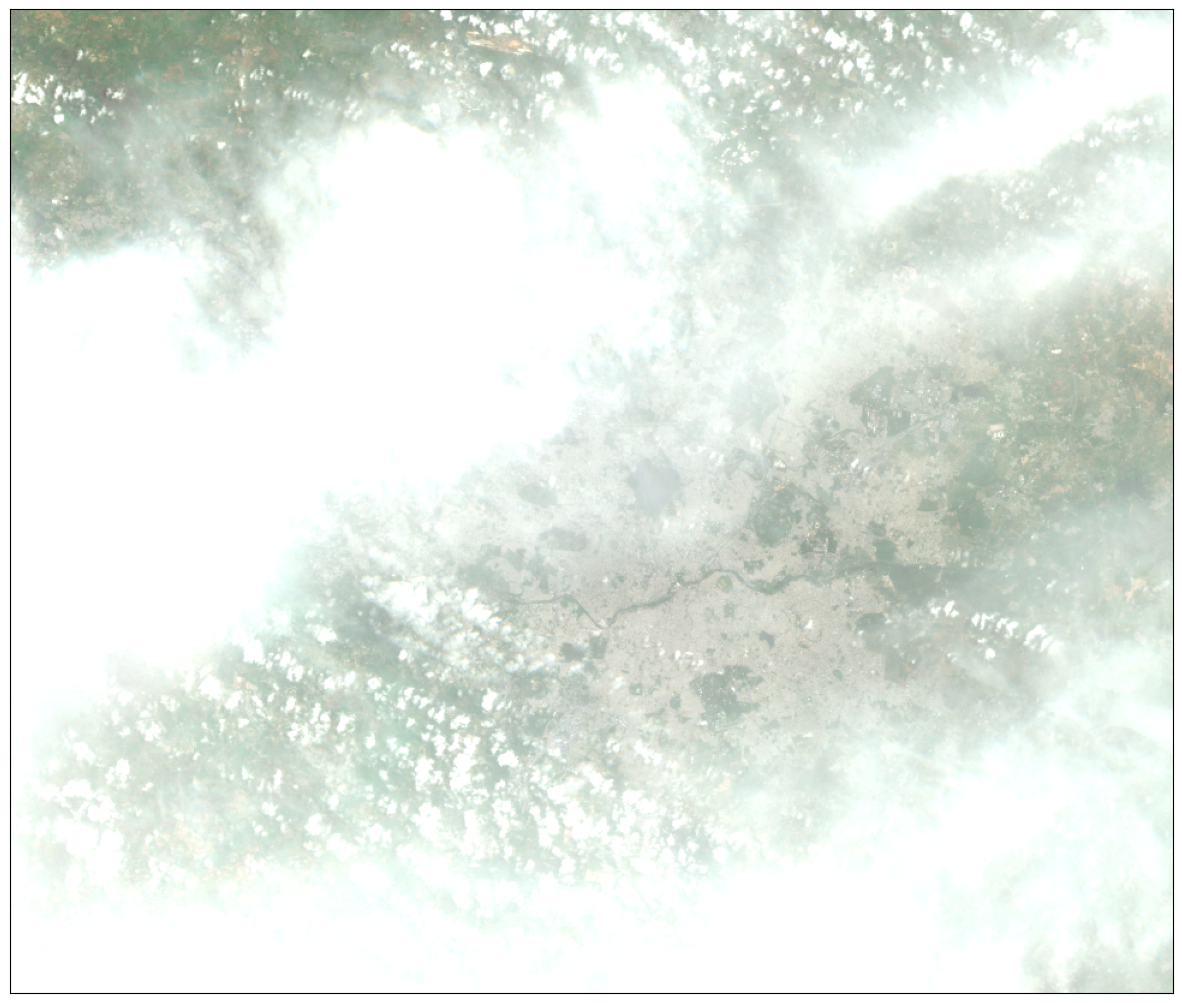

In [7]:
%matplotlib inline

# The following is not a package. It is a file utils.py which should be in the same folder as this notebook.
from utils import plot_image

plot_image(image, factor=3.5 / 255, clip_range=(0, 1))